In [1]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Flatten, Dense, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255

img_width = x_train[0].shape[0]
img_height = x_train[0].shape[1]

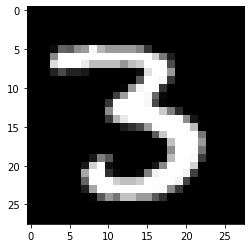

In [3]:
plt.imshow(x_train[12], cmap='gray')

In [4]:
latent_dim = 2
input_img = Input(shape=(img_width, img_height))
x = Flatten()(input_img)
x = Dense(500, activation='relu')(x)
x = Dense(120, activation='relu')(x)
z_mu = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)

def sample_z(args):
    z_mu, z_log_sigma = args
    eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
    return z_mu + K.exp(z_log_sigma/2) * eps

z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_log_sigma])
encoder = Model(input_img, [z_mu, z_log_sigma, z], name='encoder')

In [5]:
decoder_input = Input(shape=(latent_dim, ))
x = Dense(120, activation='relu')(decoder_input)
x = Dense(500, activation='relu')(x)
x = Dense(img_width * img_height, activation='sigmoid')(x)
decoder = Model(decoder_input, x, name='decoder')

In [6]:
z_decoded = decoder(z)

In [7]:
class CustomLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        recon_loss = K.sum(K.square(x-z_decoded))
        # KL divergence
        kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mu) - K.square(K.exp(z_log_sigma)), axis=-1)
        return K.mean(recon_loss + kl_loss)

    # add custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

In [8]:
y = CustomLayer()([input_img, z_decoded])

In [9]:
stop = keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5)
vae = Model(input_img, y, name='vae')

# Compile VAE
vae.compile(optimizer='adam', loss=None)

# Train autoencoder
vae.fit(x_train, None, epochs = 50, batch_size = 32, validation_split = 0.2, callbacks=[stop])

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
47296/48000 [============================>.] - ETA: 0s - loss: 1269.9246

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


48000/48000 [==============================] - 7s 142us/sample - loss: 1267.8439 - val_loss: 1094.1803
Epoch 2/50
48000/48000 [==============================] - 7s 140us/sample - loss: 1072.0153 - val_loss: 1036.3438
Epoch 3/50
48000/48000 [==============================] - 4s 75us/sample - loss: 1027.0466 - val_loss: 999.7148
Epoch 4/50
48000/48000 [==============================] - 8s 172us/sample - loss: 1001.3709 - val_loss: 985.3044
Epoch 5/50
48000/48000 [==============================] - 3s 61us/sample - loss: 983.4125 - val_loss: 983.6076
Epoch 6/50
48000/48000 [==============================] - 3s 69us/sample - loss: 971.0720 - val_loss: 961.7495
Epoch 7/50
48000/48000 [==============================] - 9s 184us/sample - loss: 959.2827 - val_loss: 953.2134
Epoch 8/50
48000/48000 [==============================] - 6s 119us/sample - loss: 951.4280 - val_loss: 943.5626
Epoch 9/50
48000/48000 [==============================] - 5s 100us/sample - loss: 944.9374 - val_loss: 943.8281


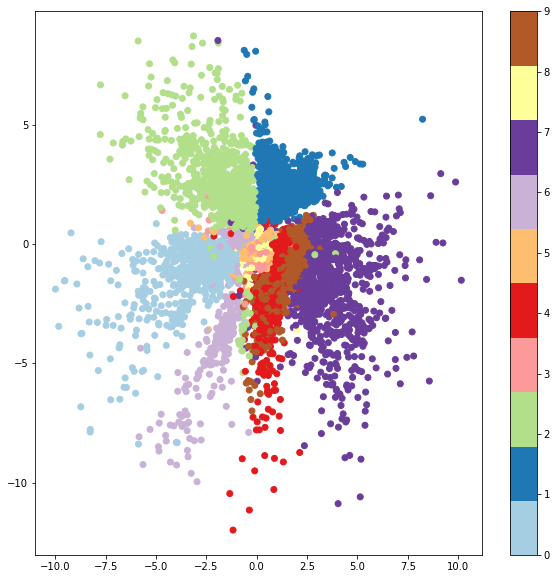

In [10]:
mu, _, _ = encoder.predict(x_test)
#Plot dim1 and dim2 for mu
plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1], c=y_test, cmap=plt.cm.get_cmap('Paired', 10))
plt.colorbar()
plt.show()

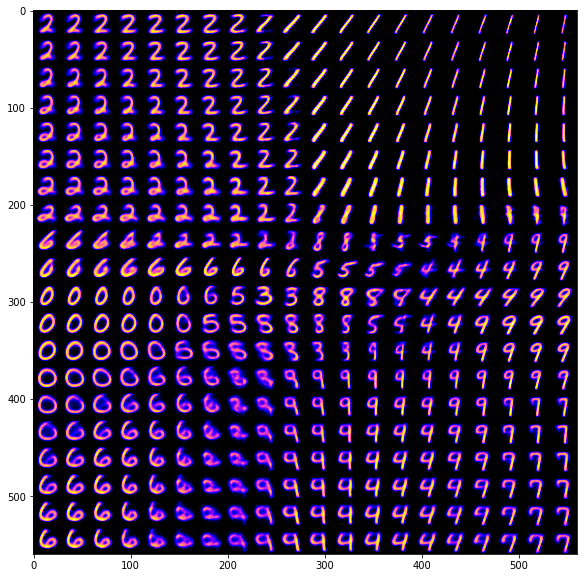

In [12]:
n = 20  # generate 15x15 digits
figure = np.zeros((img_width * n, img_height * n, 1))

#Create a Grid of latent variables, to be provided as inputs to decoder.predict
#Creating vectors within range -5 to 5 as that seems to be the range in latent space
grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-4, 4, n)[::-1]

# decoder for each square in the grid
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(img_width, img_height, 1)
        figure[i * img_width: (i + 1) * img_width,
               j * img_width: (j + 1) * img_height] = digit

plt.figure(figsize=(10, 10))
#Reshape for visualization
fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1]))

plt.imshow(figure, cmap='gnuplot2')
plt.show()  